### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'BR_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_WO', 'SVM_poly_WO','XGBoost_WO']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
# Bayesian Ridge Imputation ---> Train set
imputed_data = train.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(imputed_data)
imputed_data = pd.DataFrame(imputer.transform(imputed_data), columns = imputed_data.columns, index=imputed_data.index )
imputed_data = pd.concat([train[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)
train = imputed_data.copy()
train.isna().sum().sum()

0

In [8]:
# Bayesian Ridge Imputation ---> Test set

imputed_data = test.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(imputed_data)
imputed_data = pd.DataFrame(imputer.transform(imputed_data), columns = imputed_data.columns, index=imputed_data.index )
imputed_data = pd.concat([test[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)
test = imputed_data.copy()
test.isna().sum().sum()

0

In [9]:
train.shape, test.shape

((1450, 48), (161, 48))

In [10]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site','id','strata','diagnosis',  'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
              'pfeffer_total','cognition', 'functionality' ]


train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [11]:
train.columns

Index(['site', 'id', 'strata', 'diagnosis', 'ifs_total_score',
       'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'barthel_total',
       'pfeffer_total', 'cognition', 'functionality'],
      dtype='object')

In [12]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 15), (161, 15))

In [13]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [14]:
### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-25/BR_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "BR_RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "BR_SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "BR_xgb_hparams.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [15]:
rf_row = 0
rf_hp.iloc[0,:]

param_criterion                                                      entropy
param_max_depth                                                           10
param_max_features                                                        10
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                       0.8765
mean_train_score                                                    0.986349
Name: 0, dtype: object

In [16]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      0.148871
param_coef0                                                         0
param_degree                                                        2
param_gamma                                                  4.898347
params              OrderedDict([('C', 0.14887107527727986), ('coe...
mean_test_score                                              0.826284
mean_train_score                                             0.893643
Name: 0, dtype: object

In [17]:
xgb_row=0
xgb_hp.iloc[0, :]

param_booster                                                     gbtree
param_learning_rate                                             0.135474
param_max_bin                                                          6
param_max_depth                                                        2
param_max_leaves                                                       8
param_n_estimators                                                   100
param_reg_alpha                                                      0.1
param_reg_lambda                                                    0.99
param_tree_method                                                 approx
params                 OrderedDict([('booster', 'gbtree'), ('learning...
mean_test_score                                                 0.853737
mean_train_score                                                0.944803
Name: 0, dtype: object

In [18]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[xgb_row, 'param_booster'],
    'tree_method': xgb_hp.loc[xgb_row, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[xgb_row, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'max_bin': xgb_hp.loc[xgb_row, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[xgb_row, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[xgb_row, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

In [19]:
n_iter =1000

### Base model: Logistic Regression

In [20]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 1000/1000 [00:36<00:00, 27.40it/s]

singular_matrix_errors (droped from results): 898
Eleapsed time:0.6087442477544148 minutes
empirical p-value: 0.001



Casting complex values to real discards the imaginary part
invalid value encountered in sqrt


In [21]:
lr_res.mean()

Accuracy         0.777964
ROC_AUC          0.714383
Precision        0.772169
Recall           0.085870
Sensitivity      0.085870
Specificity      0.991631
F1               0.152422
Efron_pR2        0.119839
mcfadden_pR2     0.109670
mcfadden_apR2   -0.016247
dtype: float64

In [22]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.02576,0.027997,0.025997,0.017365,0.017365,0.005646,0.022278,0.02013,0.019368,NaN


In [23]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,ace_lw,1.452096,0.118972,4.787255e-05-1.124510e-05j,0.000221,1.000000,0.000000e+00
1,ace_vs,1.429668,0.126648,2.451961e-05-1.102941e-05j,0.000103,0.999999,3.330669e-16
2,barthel_total,0.295483,0.081858,3.159667e-03+5.052941e-05j,0.001232,0.999141,3.330669e-16
3,cognition,0.612017,0.045735,4.607843e-07-1.666667e-07j,0.000001,1.000000,0.000000e+00
4,functionality,-0.299471,0.082009,-1.417353e-03+6.186275e-06j,0.000794,0.999845,3.330669e-16


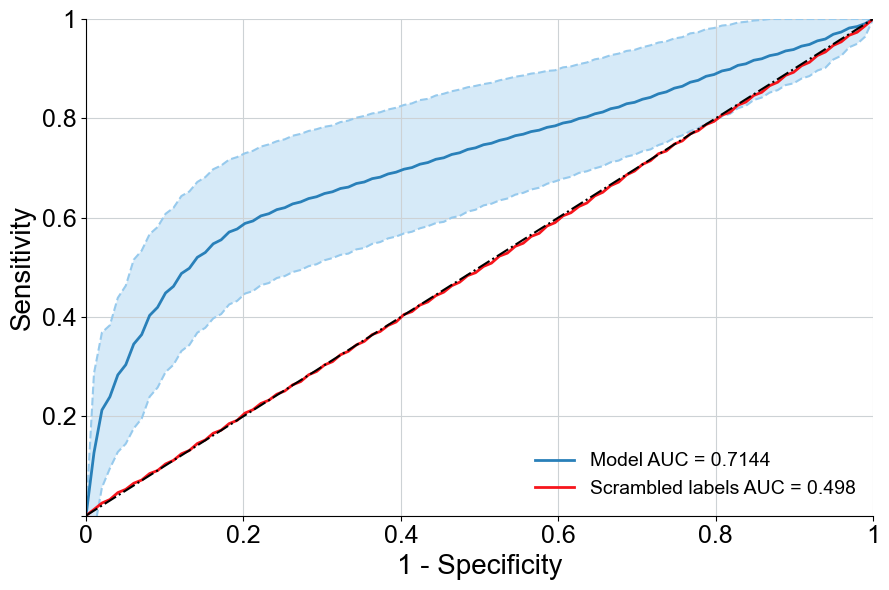

In [24]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [25]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
rf_fimp.sort_values('mean', ascending=False)#.to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

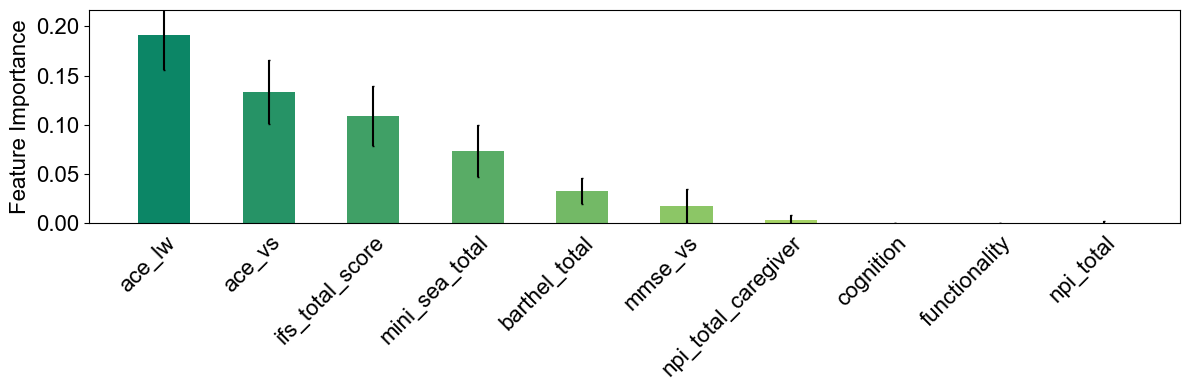

In [27]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

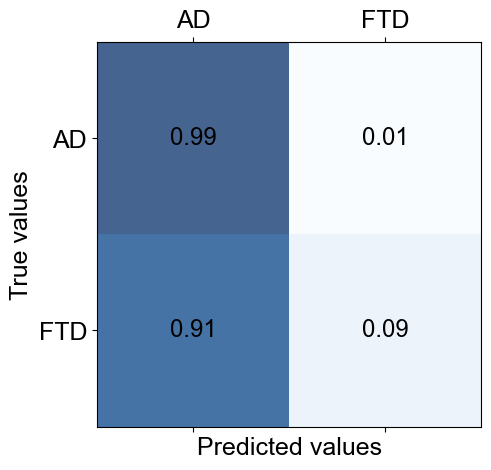

In [28]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [29]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [30]:
np.linspace(0.1, 1, num=10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [31]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [32]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [33]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5478
Accuracy: 0.7757
Recall: 0.12
F1: 0.2
Precision:0.6


In [34]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5478
Bootstrping test ROC score: 	0.7144


### RF Model

##### Bootstrap

In [35]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=10, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|██████████████████| 1000/1000 [17:18<00:00,  1.04s/it]

singular_matrix_errors (droped from results): 0
Eleapsed time:17.310887904961906 minutes
empirical p-value: 0.0


In [36]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-09-25/BR_res'

In [37]:
Model_res.to_csv(path_res+ "/RandomForest_WO/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.796308
ROC_AUC        0.831083
Precision      0.562764
Recall         0.634435
Sensitivity    0.634435
Specificity    0.846282
F1             0.594530
Efron_pR2      0.210313
dtype: float64

In [38]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8311


In [39]:
CI_df.to_csv(path_res+ "/RandomForest_WO/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.024962,0.023223,0.030745,0.029849,0.029849,0.022355,0.030431,0.025259


In [40]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
6,mini_sea_total,0.251625,0.012170
5,ifs_total_score,0.115688,0.010888
12,npi_total_caregiver,0.096069,0.010214
0,ace_lw,0.086732,0.014064
11,npi_total,0.077357,0.007753
1,ace_vs,0.063265,0.011938
3,cognition,0.062121,0.009179
13,pfeffer_total,0.056767,0.005943
2,barthel_total,0.056359,0.006714
4,functionality,0.040706,0.004961


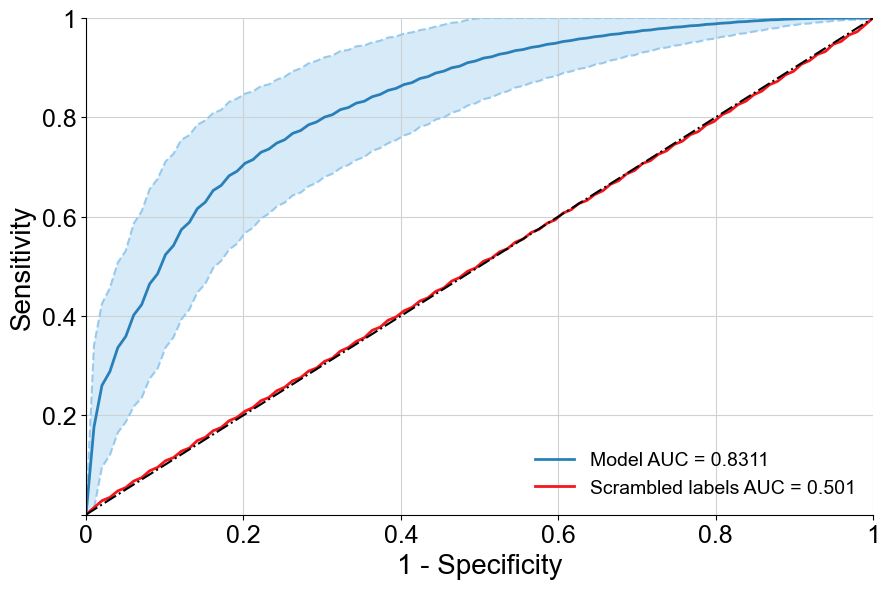

In [41]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest_WO/ROC_AUC_curve.png")
# Fig save?


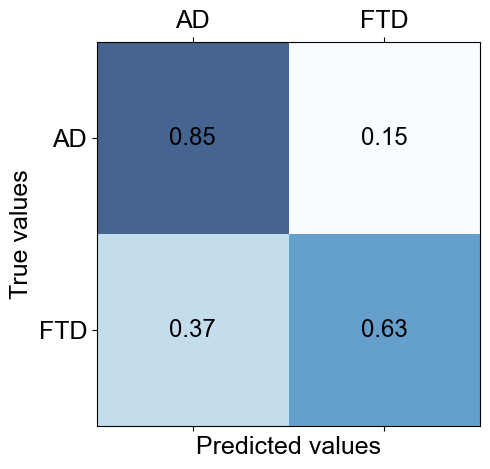

In [42]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_WO/CM.png")

##### Permutation Feature importance

In [43]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [44]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest_WO/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [45]:
top_10p.head()

,predictor,mean,std
1,mini_sea_total,0.104863,0.030034
9,ace_lw,0.046474,0.016900
0,ifs_total_score,0.023110,0.014651
12,cognition,0.019214,0.005865
3,npi_total_caregiver,0.019050,0.005827


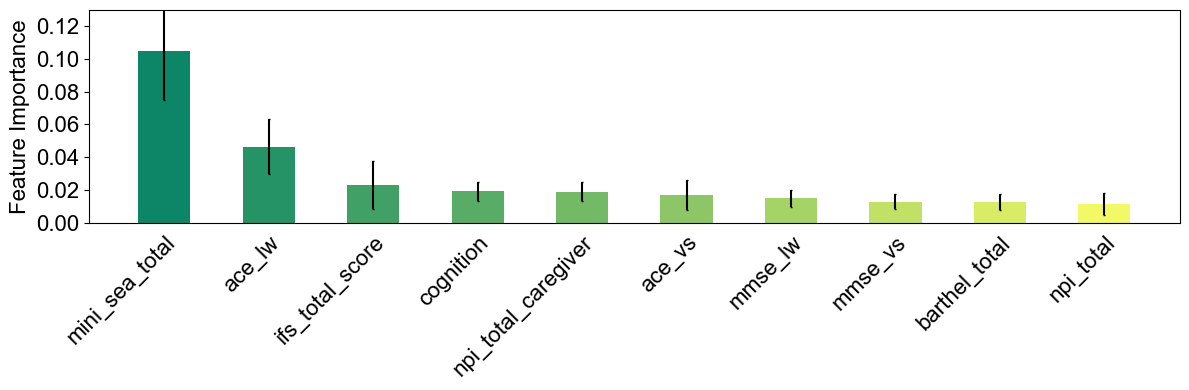

In [46]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [47]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
6,mini_sea_total,0.251625,0.012170
5,ifs_total_score,0.115688,0.010888
12,npi_total_caregiver,0.096069,0.010214
0,ace_lw,0.086732,0.014064
11,npi_total,0.077357,0.007753


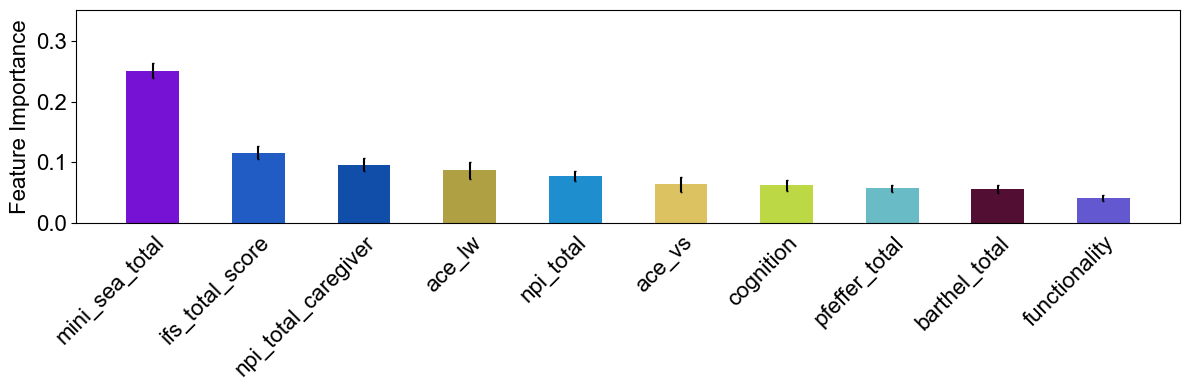

In [48]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [49]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [50]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

In [51]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest_WO/unseen.csv")

In [52]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.6424
Accuracy: 0.729
Recall: 0.48
F1: 0.4528
Precision:0.4286


In [53]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.6424
Bootstrping test ROC score: 	0.8311


#### Shapley

In [54]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


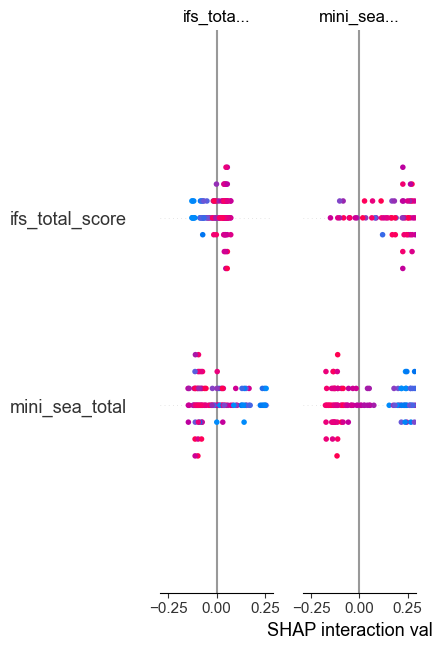

In [55]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

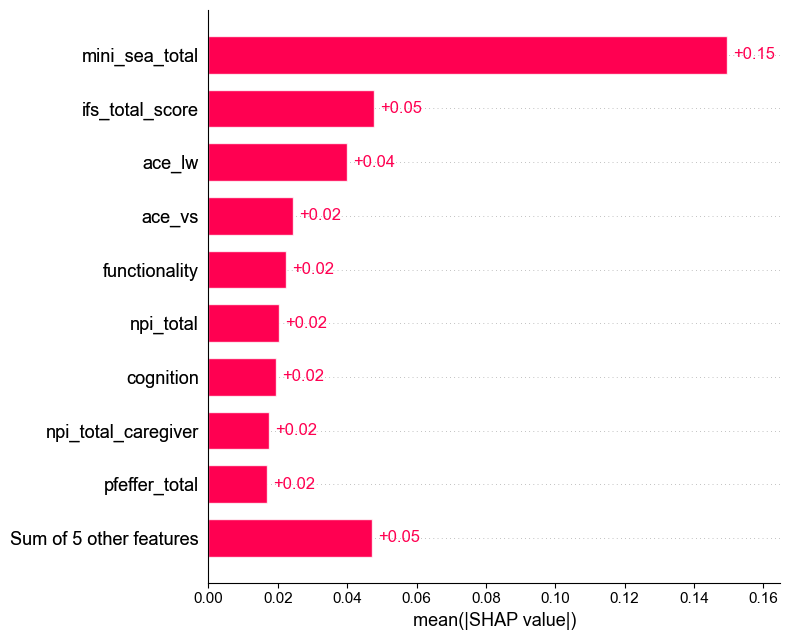

In [56]:
shap.plots.bar(shap_values[:,:,1])

In [57]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [58]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [59]:
# shap.summary_plot(shap_values2[:,:,1])

In [60]:
# shap.plots.bar(shap_values2[:,:,1])

In [61]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [62]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [63]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=0.1488710752772798, class_weight='balanced', coef0=0, degree=2,
    gamma=4.898346619162522, kernel='poly', verbose=0)


Iterating: 100%|██████████████████| 1000/1000 [00:48<00:00, 20.48it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:0.8139374812444051 minutes
empirical p-value: 0.001


In [64]:
p_Model_res.to_csv(path_res+ "/SVM_poly_WO/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.748590
ROC_AUC        0.692197
Precision      0.475843
Recall         0.585435
Sensitivity    0.585435
Specificity    0.798960
F1             0.523232
dtype: float64

In [65]:
p_CI_df.to_csv(path_res+ "/SVM_poly_WO/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.026889
ROC_AUC_ci        0.028609
Precision_ci      0.030954
Recall_ci         0.030535
Sensitivity_ci    0.030535
Specificity_ci    0.024840
F1_ci             0.030957
dtype: float64

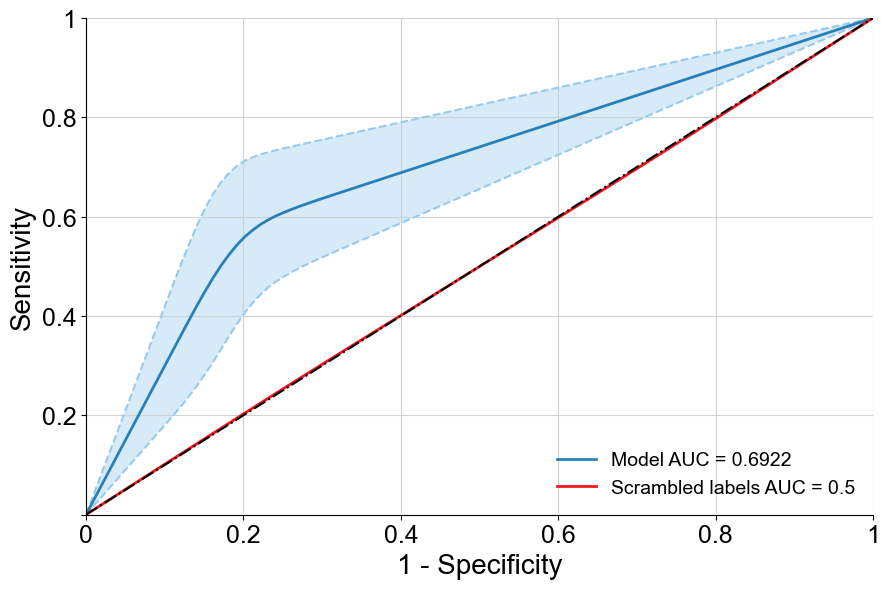

In [66]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly_WO/poly_ROC_AUC_curve.png")

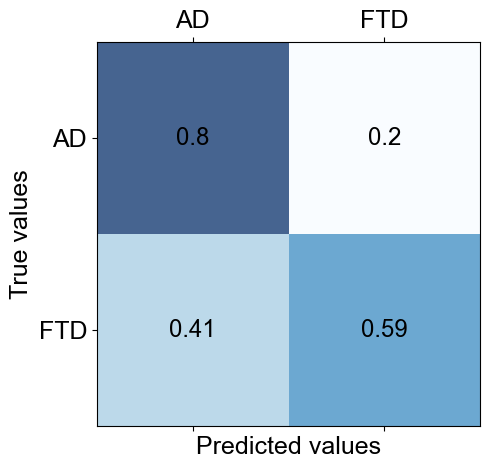

In [67]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly_WO/poly_CM.png")

#### Permutation Feature importance

In [68]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly_WO/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


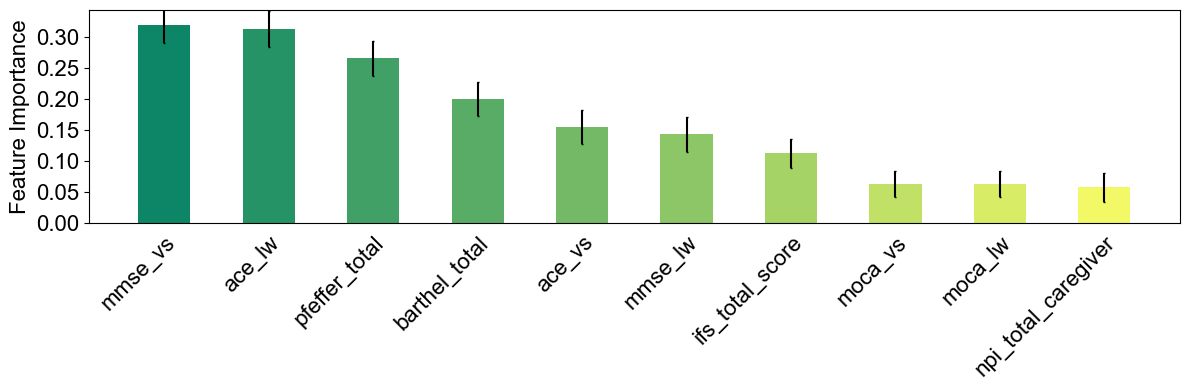

In [69]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [70]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [71]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly_WO/poly_PFI.csv")

In [72]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.4837
Accuracy: 0.3364
Recall: 0.76
F1: 0.3486
Precision:0.2262

Unseen Data ROC score: 		0.4837
Bootstrping test ROC score: 	0.6922


#### Shapley

In [73]:
poly_params['probability'] = True

In [74]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

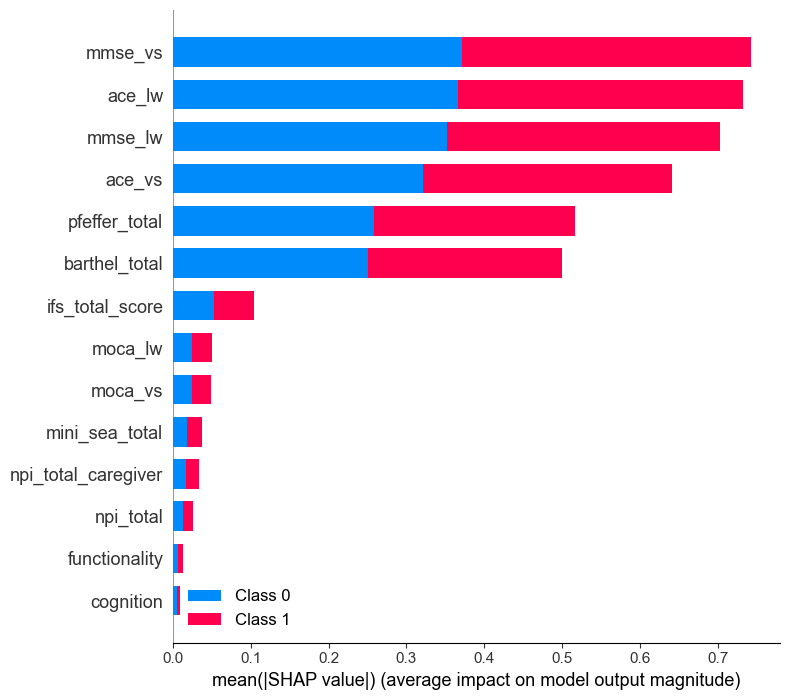

In [75]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

#### Bootstrap

In [76]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 1000/1000 [02:20<00:00,  7.14it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:2.3344849824905394 minutes
empirical p-value: 0.0


In [77]:
xgb_Model_res.to_csv(path_res+ "/XGBoost_WO/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.797579
ROC_AUC        0.800939
Precision      0.622257
Recall         0.376152
Sensitivity    0.376152
Specificity    0.927685
F1             0.465224
Efron_pR2      0.217967
dtype: float64

In [78]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost_WO/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
6,mini_sea_total,53.833,6.713135,5.763885,0.655500
5,ifs_total_score,42.287,6.439884,3.525194,0.692119
11,npi_total_caregiver,29.639,6.011057,2.015189,0.374368
10,npi_total,26.460,6.416820,2.184822,0.459229
2,barthel_total,24.249,8.130997,2.418356,0.680704
1,ace_vs,23.569,6.489789,3.121499,0.751291
8,mmse_vs,23.340,6.311754,4.893961,1.169813
12,pfeffer_total,20.613,5.518123,3.107632,0.730695
9,moca_vs,20.464,6.037811,1.806640,0.539499
3,cognition,14.849,5.821004,4.369029,2.058083


In [79]:
xgb_CI_df.to_csv(path_res+ "/XGBoost_WO/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.024904,0.024749,0.03005,0.030025,0.030025,0.016054,0.030915,0.02559


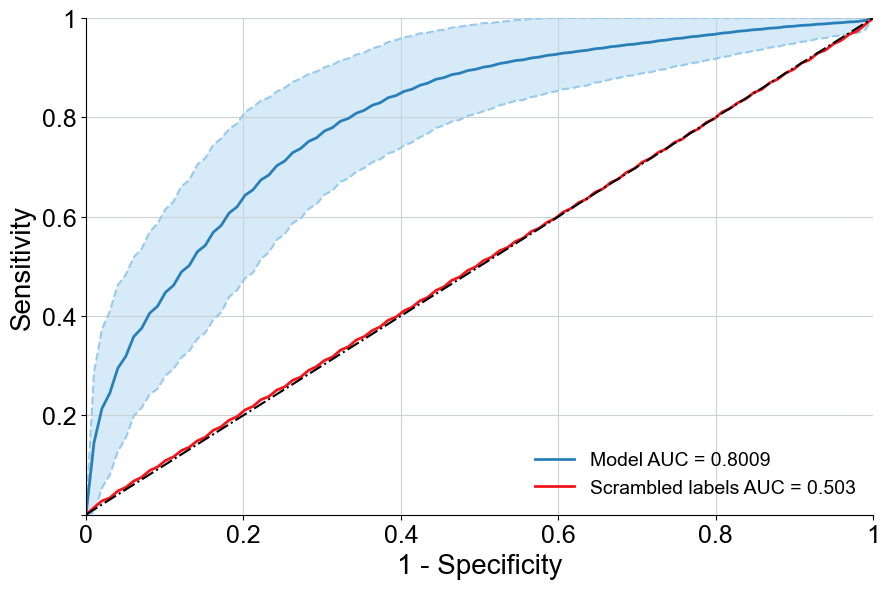

In [80]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost_WO/xgb_ROC.png")

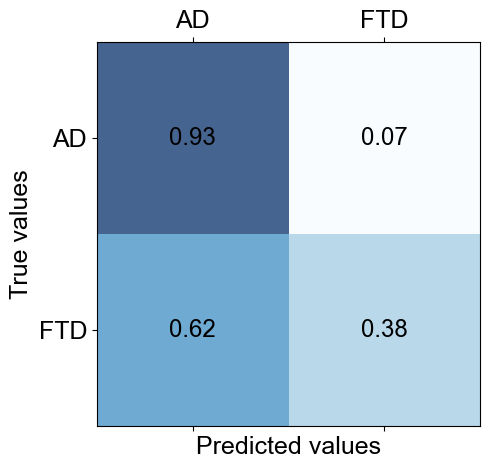

In [81]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost_WO/xgb_CM.png")

#### Permutation Feature importance

In [82]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost_WO/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

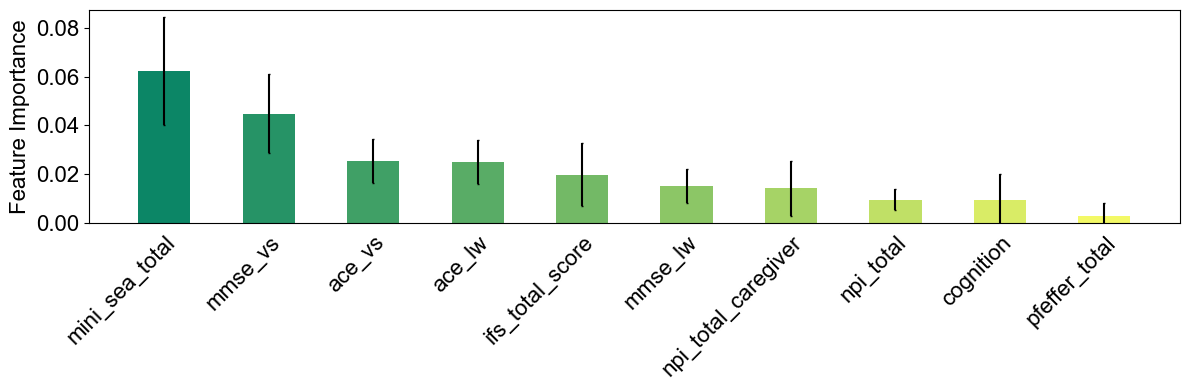

In [83]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [84]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,ace_lw,10.023000,4.333041,6.833311,3.137632
1,ace_vs,23.569000,6.489789,3.121499,0.751291
2,barthel_total,24.249000,8.130997,2.418356,0.680704
3,cognition,14.849000,5.821004,4.369029,2.058083
4,functionality,4.368421,3.267895,4.806368,2.057019
5,ifs_total_score,42.287000,6.439884,3.525194,0.692119
6,mini_sea_total,53.833000,6.713135,5.763885,0.655500
7,mmse_lw,6.786573,2.875124,10.683419,4.002724
8,mmse_vs,23.340000,6.311754,4.893961,1.169813
9,moca_vs,20.464000,6.037811,1.806640,0.539499


In [85]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
6,mini_sea_total,53.833,6.713135,5.763885,0.655500
5,ifs_total_score,42.287,6.439884,3.525194,0.692119
11,npi_total_caregiver,29.639,6.011057,2.015189,0.374368
10,npi_total,26.460,6.416820,2.184822,0.459229
2,barthel_total,24.249,8.130997,2.418356,0.680704
1,ace_vs,23.569,6.489789,3.121499,0.751291
8,mmse_vs,23.340,6.311754,4.893961,1.169813
12,pfeffer_total,20.613,5.518123,3.107632,0.730695
9,moca_vs,20.464,6.037811,1.806640,0.539499
3,cognition,14.849,5.821004,4.369029,2.058083


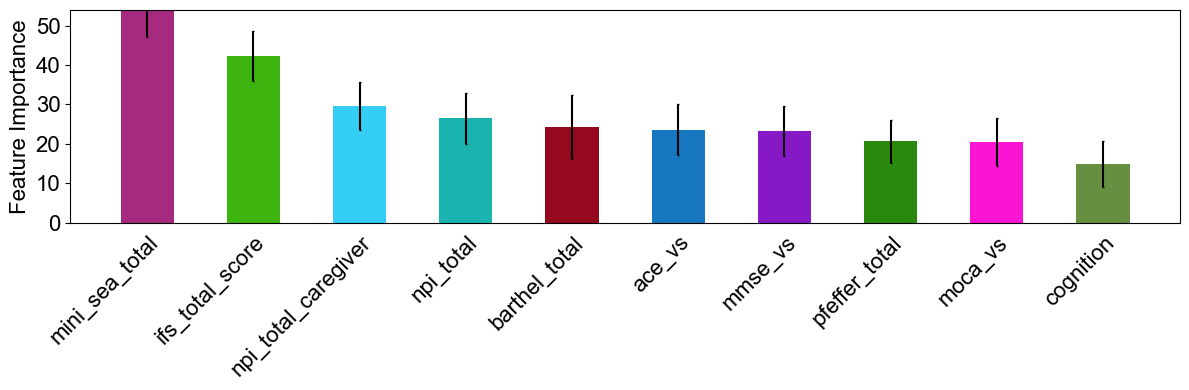

In [86]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

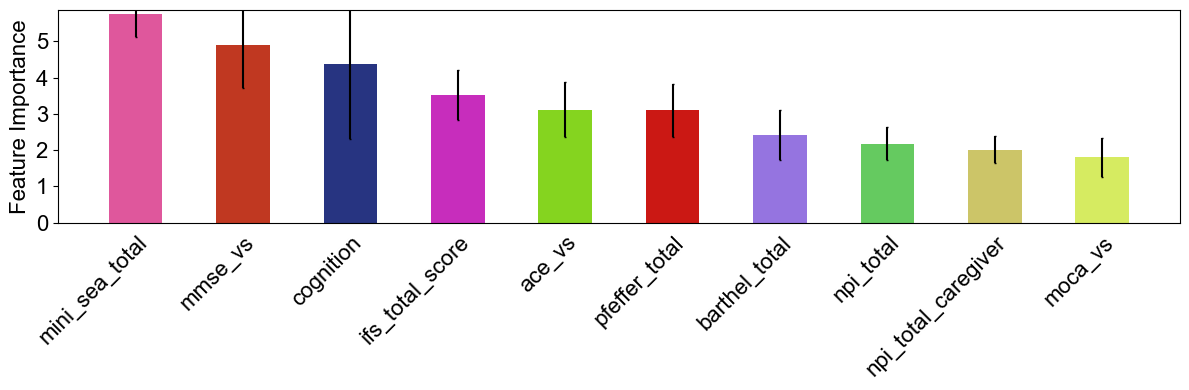

In [87]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [88]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [89]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost_WO/xgb_PFI.csv")

In [90]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6539
Accuracy: 0.8318
Recall: 0.32
F1: 0.4706
Precision:0.8889

Unseen Data ROC score: 		0.6539
Bootstrping test ROC score: 	0.8009


#### Shapley

In [91]:
# # compute SHAP values
# explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
# shap_values = explainer(X_train, check_additivity=False)

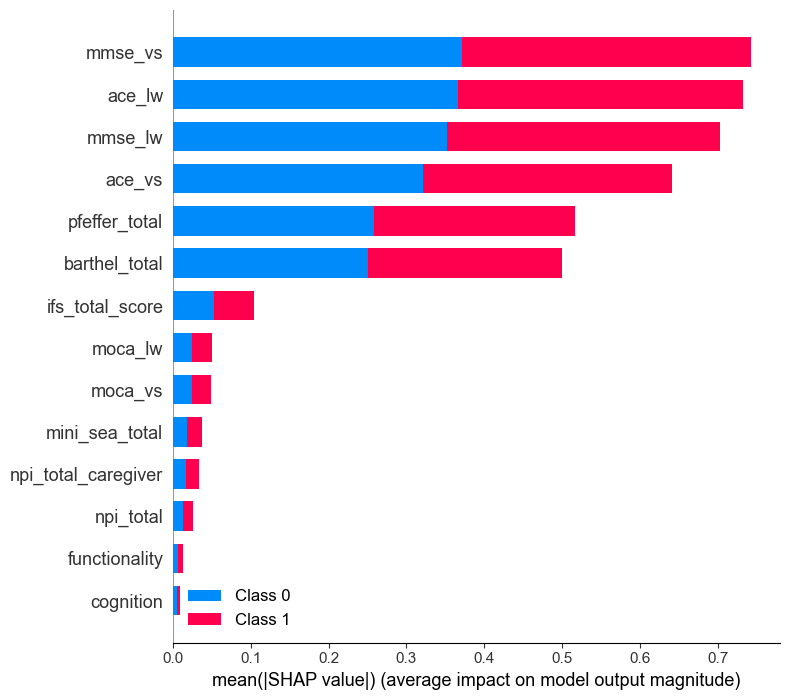

In [92]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

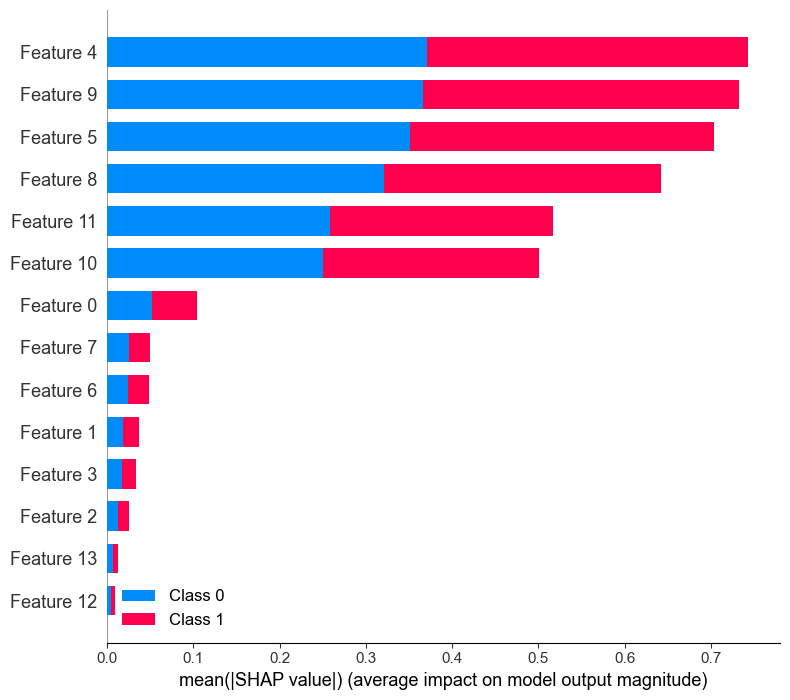

In [93]:
shap.summary_plot(shap_values)

In [94]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [119]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [120]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [121]:
rf_params

{'n_estimators': 500,
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 10,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [122]:
sfs_rfc = SFS(RandomForestClassifier(class_weight= 'balanced'), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [123]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.5s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.5s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.5s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.5s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [124]:
pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(12,)","[0.7446153846153846, 0.6861538461538461, 0.740...",0.723837,"(cognition,)",0.060067,0.026693,0.018875
2,"(1, 12)","[0.7630769230769231, 0.7661538461538462, 0.774...",0.767974,"(mini_sea_total, cognition)",0.011056,0.004913,0.003474
3,"(0, 1, 12)","[0.7846153846153846, 0.8246153846153846, 0.783...",0.797727,"(ifs_total_score, mini_sea_total, cognition)",0.04279,0.019015,0.013445
4,"(0, 1, 11, 12)","[0.803076923076923, 0.8276923076923077, 0.8179...",0.816223,"(ifs_total_score, mini_sea_total, pfeffer_tota...",0.022771,0.010119,0.007155
5,"(0, 1, 8, 11, 12)","[0.8153846153846154, 0.8276923076923077, 0.833...",0.82547,"(ifs_total_score, mini_sea_total, ace_vs, pfef...",0.016864,0.007494,0.005299
6,"(0, 1, 7, 8, 11, 12)","[0.8153846153846154, 0.8307692307692308, 0.817...",0.821352,"(ifs_total_score, mini_sea_total, moca_lw, ace...",0.015163,0.006738,0.004764
7,"(0, 1, 4, 7, 8, 11, 12)","[0.803076923076923, 0.84, 0.8333333333333334]",0.82547,"(ifs_total_score, mini_sea_total, mmse_vs, moc...",0.036155,0.016067,0.011361
8,"(0, 1, 2, 4, 7, 8, 11, 12)","[0.8153846153846154, 0.8338461538461538, 0.814...",0.821349,"(ifs_total_score, mini_sea_total, npi_total, m...",0.019893,0.00884,0.006251
9,"(0, 1, 2, 4, 7, 8, 11, 12, 13)","[0.8153846153846154, 0.8215384615384616, 0.814...",0.817246,"(ifs_total_score, mini_sea_total, npi_total, m...",0.00685,0.003044,0.002153
10,"(0, 1, 2, 4, 6, 7, 8, 11, 12, 13)","[0.8153846153846154, 0.8338461538461538, 0.805...",0.818262,"(ifs_total_score, mini_sea_total, npi_total, m...",0.026391,0.011727,0.008293


In [125]:
from sklearn.feature_selection import SequentialFeatureSelector as ssfs
from sklearn.feature_selection import RFECV

In [126]:
rfecv_rf = RFECV(RandomForestClassifier(class_weight= 'balanced'), step=1, min_features_to_select=5, cv=cv, scoring='roc_auc', verbose=1,
      n_jobs=-1, importance_getter='auto')

In [127]:
rfecv_rf=rfecv_rf.fit(X_train, y_train)

Fitting estimator with 14 features.


In [128]:
X_train.columns[rfecv_rf.support_]

Index(['ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'mmse_lw', 'moca_vs', 'ace_vs', 'ace_lw', 'barthel_total',
       'pfeffer_total', 'cognition', 'functionality'],
      dtype='object')

### XBoost

In [129]:
sfs_xgb = SFS(xgboost.XGBClassifier(), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [130]:
sfs_xgb = sfs_xgb.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.1s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    0.2s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [131]:
pd.DataFrame.from_dict(sfs_xgb.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.7753846153846153, 0.7784615384615384, 0.783...",0.779266,"(mmse_vs,)",0.007973,0.003543,0.002505
2,"(1, 4)","[0.7815384615384615, 0.7784615384615384, 0.780...",0.780288,"(mini_sea_total, mmse_vs)",0.002972,0.001321,0.000934
3,"(1, 4, 10)","[0.7876923076923077, 0.7692307692307693, 0.796...",0.784406,"(mini_sea_total, mmse_vs, barthel_total)",0.025409,0.011291,0.007984
4,"(0, 1, 4, 10)","[0.803076923076923, 0.7876923076923077, 0.8055...",0.798775,"(ifs_total_score, mini_sea_total, mmse_vs, bar...",0.017781,0.007902,0.005587
5,"(0, 1, 2, 4, 10)","[0.8276923076923077, 0.796923076923077, 0.8055...",0.810057,"(ifs_total_score, mini_sea_total, npi_total, m...",0.029161,0.012958,0.009163
6,"(0, 1, 2, 4, 8, 10)","[0.8276923076923077, 0.796923076923077, 0.8086...",0.811086,"(ifs_total_score, mini_sea_total, npi_total, m...",0.028534,0.01268,0.008966
7,"(0, 1, 2, 4, 8, 10, 11)","[0.8307692307692308, 0.803076923076923, 0.8179...",0.817249,"(ifs_total_score, mini_sea_total, npi_total, m...",0.025462,0.011315,0.008001
8,"(0, 1, 2, 4, 8, 9, 10, 11)","[0.8338461538461538, 0.8123076923076923, 0.808...",0.818265,"(ifs_total_score, mini_sea_total, npi_total, m...",0.02502,0.011119,0.007862
9,"(0, 1, 2, 4, 8, 9, 10, 11, 13)","[0.8338461538461538, 0.8092307692307692, 0.808...",0.81724,"(ifs_total_score, mini_sea_total, npi_total, m...",0.02643,0.011745,0.008305
10,"(0, 1, 2, 4, 6, 8, 9, 10, 11, 13)","[0.8246153846153846, 0.8092307692307692, 0.799...",0.811076,"(ifs_total_score, mini_sea_total, npi_total, m...",0.023366,0.010384,0.007342


In [132]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

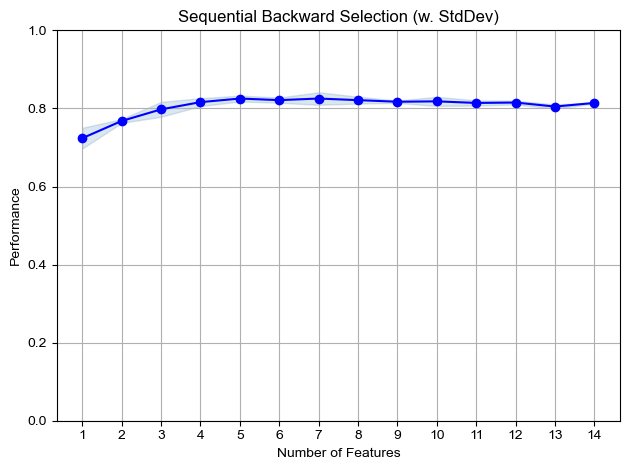

In [133]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0., 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

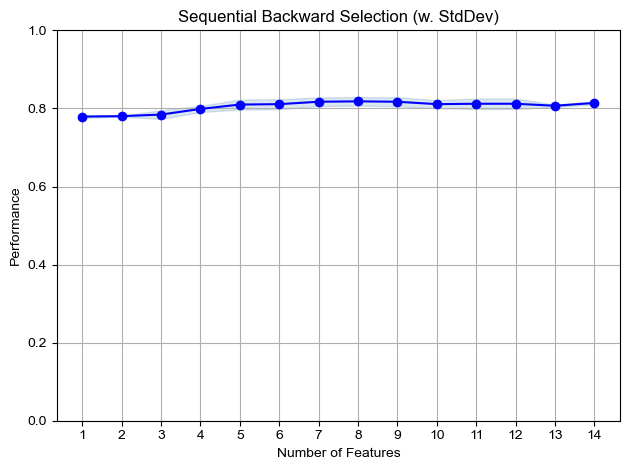

In [134]:
fig2 = plot_sfs(sfs_xgb.get_metric_dict(), kind='std_dev')


plt.ylim([0., 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()